Loading and merging datasets...
Loaded 464 rows from benchmark_temp0.3_run3.csv
Loaded 464 rows from benchmark_temp0.3_run2.csv
Loaded 464 rows from benchmark_temp0.3_run1.csv
Loaded 116 rows from granite_speech_benchmark_run1_temp0.3.csv
Loaded 116 rows from granite_speech_benchmark_run2_temp0.3.csv
Loaded 116 rows from granite_speech_benchmark_run3_temp0.3.csv

Merged 1740 total rows from 6 files
Cleaning and normalizing data...
After cleaning: 1740 rows
Unique models: ['whisper' 'distil_whisper' 'wav2vec2' 'parakeet' 'granite-speech-3.3']
Unique categories: ['clean' 'noisy']
Computing CERs...

SUMMARY STATISTICS
             model category  wer_mean  wer_std  sample_count  cer_mean  cer_std  ins_mean  del_mean  sub_mean
    distil_whisper    clean    0.1493   0.1275           174    0.0797   0.0690    1.3563    1.4195    4.6437
    distil_whisper    noisy    0.2126   0.1916           174    0.1231   0.1144    1.6379    2.0517    6.8218
granite-speech-3.3    clean    0.0818   0.1189 

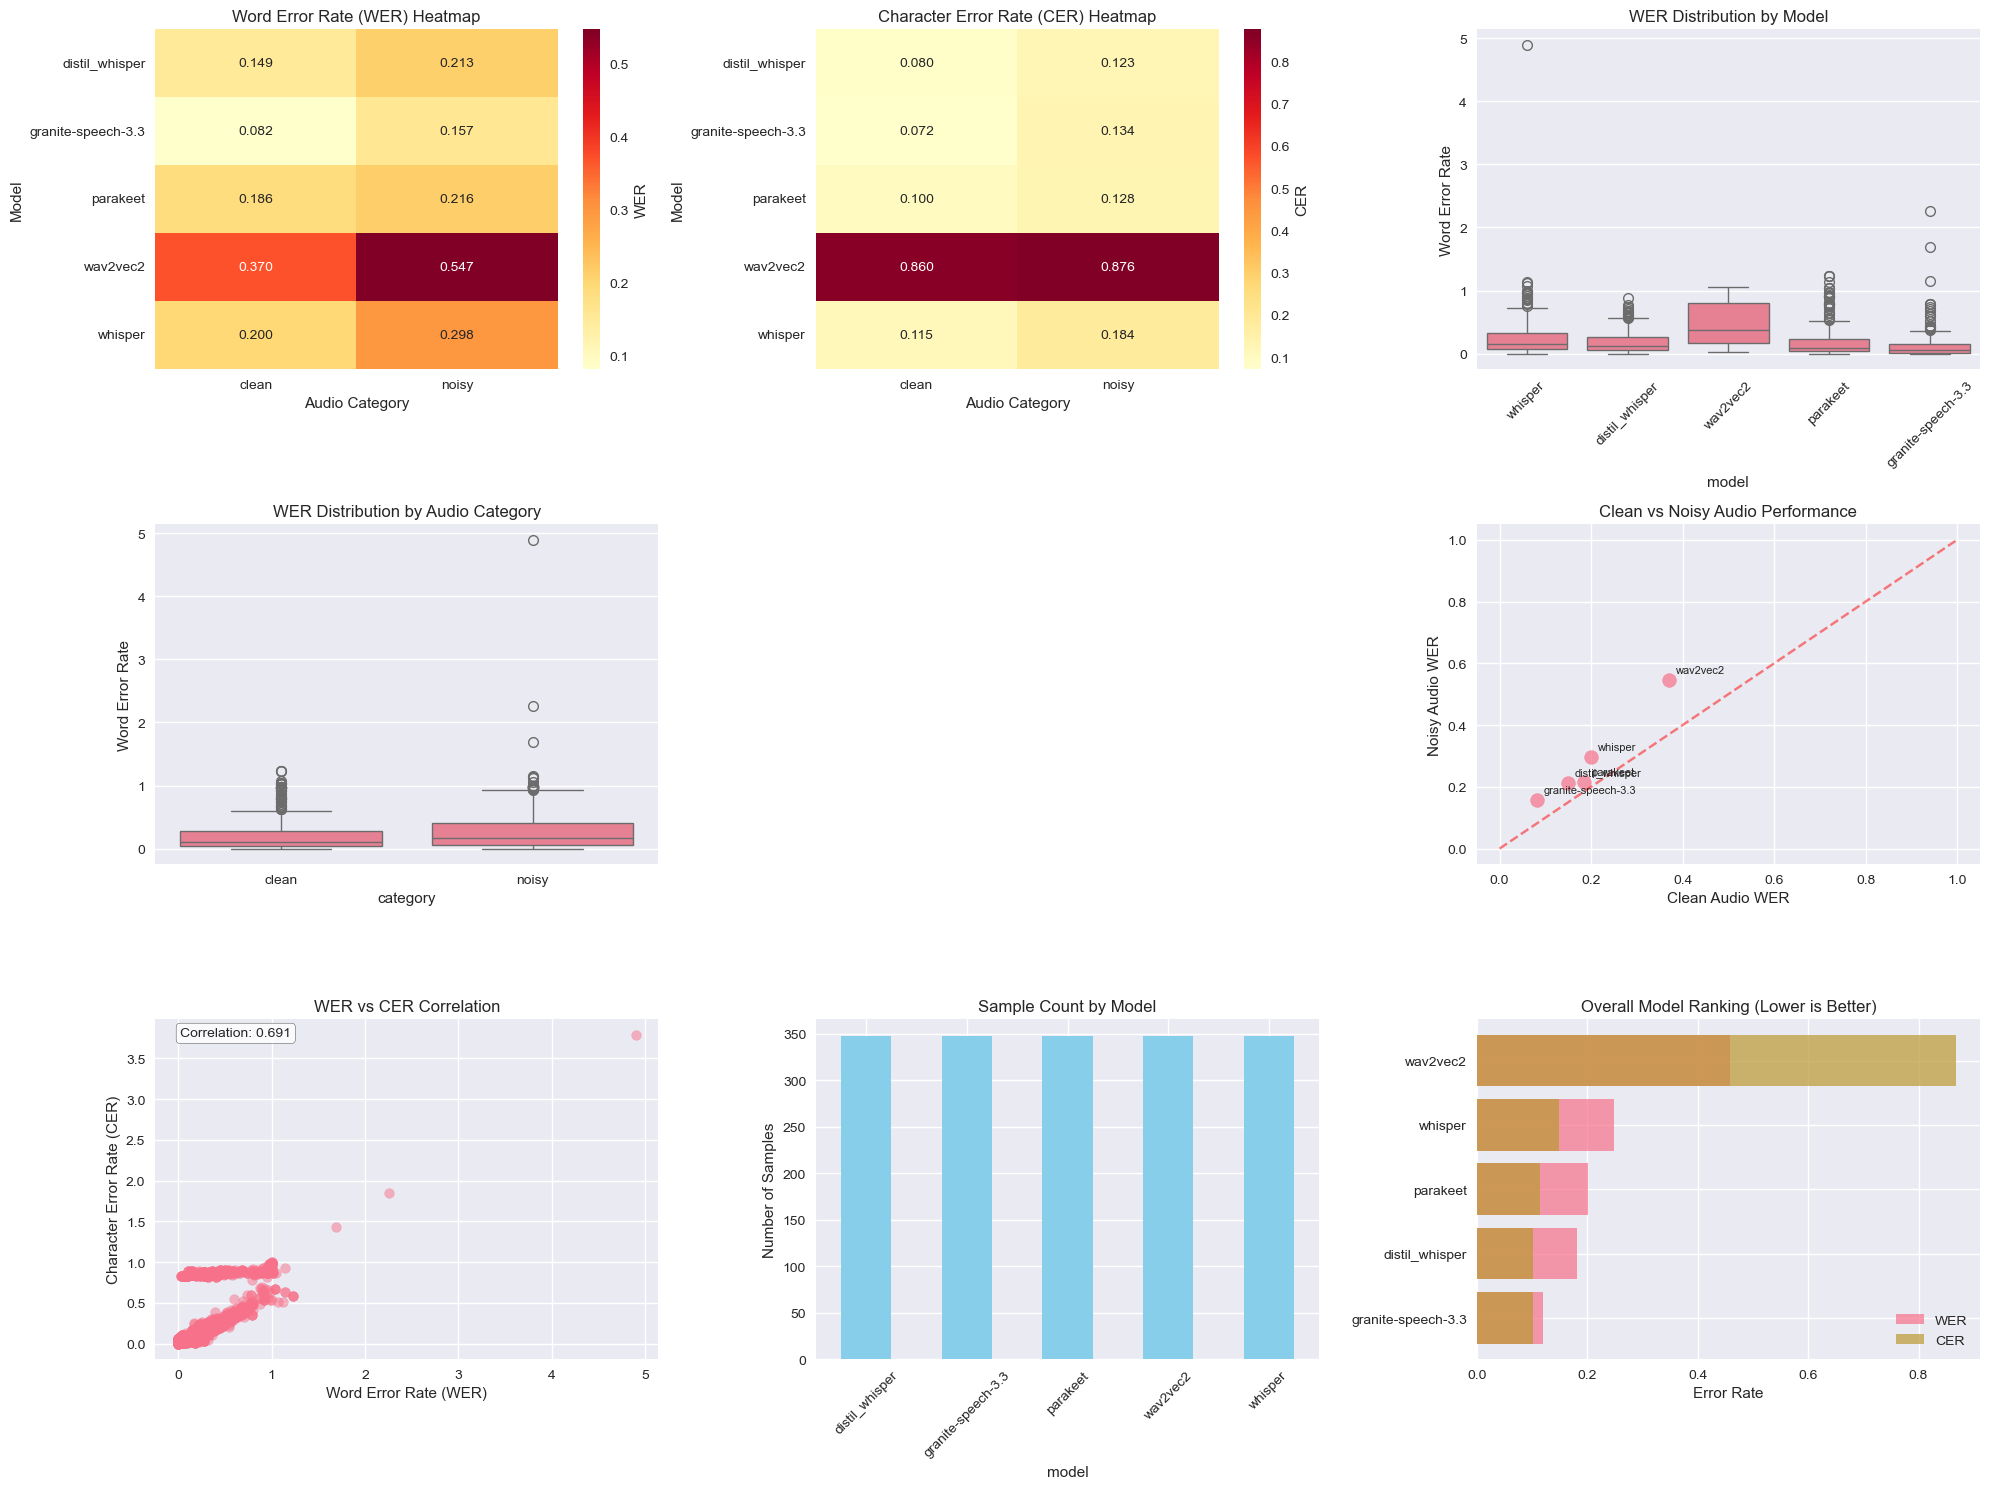


DETAILED ANALYSIS
Best overall model (WER): granite-speech-3.3 (0.1195)
Best overall model (CER): distil_whisper (0.1014)

Performance by category:
  Clean: granite-speech-3.3 (0.0818 WER)
  Noisy: granite-speech-3.3 (0.1572 WER)

Model comparison summary:
                       wer                                   cer        
                      mean     std count     min     max    mean     std
model                                                                   
distil_whisper      0.1809  0.1656   348  0.0000  0.8772  0.1014  0.0968
granite-speech-3.3  0.1195  0.2075   348  0.0000  2.2600  0.1026  0.1579
parakeet            0.2007  0.2690   348  0.0000  1.2281  0.1141  0.1602
wav2vec2            0.4587  0.3285   348  0.0333  1.0526  0.8679  0.0366
whisper             0.2488  0.3439   348  0.0000  4.8947  0.1494  0.2539


PermissionError: [Errno 13] Permission denied: 'merged_speech_benchmark_results.csv'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jiwer import cer
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
original_csv_paths = [
    r"C:\Users\jairo\Downloads\benchmark_temp0.3_run3.csv",
    r"C:\Users\jairo\Downloads\benchmark_temp0.3_run2.csv",
    r"C:\Users\jairo\Downloads\benchmark_temp0.3_run1.csv",
]
granite_csv_paths = [
    r"C:\Users\jairo\Downloads\granite_speech_benchmark_run1_temp0.3.csv",
    r"C:\Users\jairo\Downloads\granite_speech_benchmark_run2_temp0.3.csv",
    r"C:\Users\jairo\Downloads\granite_speech_benchmark_run3_temp0.3.csv",
]

print("Loading and merging datasets...")

# Load original benchmark data
df_list = []
for file in original_csv_paths:
    try:
        temp_df = pd.read_csv(file)
        temp_df["source_file"] = file.split("\\")[-1]  # Use \\ for Windows paths
        temp_df["dataset_type"] = "original_benchmark"
        df_list.append(temp_df)
        print(f"Loaded {len(temp_df)} rows from {file.split('\\')[-1]}")
    except FileNotFoundError:
        print(f"File not found: {file}")

# Load Granite model data
for file in granite_csv_paths:
    try:
        temp_df = pd.read_csv(file)
        temp_df["source_file"] = file.split("\\")[-1]
        temp_df["dataset_type"] = "granite_benchmark"
        df_list.append(temp_df)
        print(f"Loaded {len(temp_df)} rows from {file.split('\\')[-1]}")
    except FileNotFoundError:
        print(f"File not found: {file}")

if not df_list:
    print("No files found! Please check your file paths.")
    exit()

# Merge all dataframes
df = pd.concat(df_list, ignore_index=True)
print(f"\nMerged {len(df)} total rows from {len(df_list)} files")

# Data cleaning and normalization
print("Cleaning and normalizing data...")
df["model"] = df["model"].str.lower().str.strip()
df["category"] = df["category"].str.lower().str.strip()
df.dropna(subset=["true_transcription", "transcription"], inplace=True)

# Replace empty transcriptions with a placeholder
df.loc[df["transcription"].str.strip() == "", "transcription"] = "[EMPTY]"

print(f"After cleaning: {len(df)} rows")
print(f"Unique models: {df['model'].unique()}")
print(f"Unique categories: {df['category'].unique()}")

# Compute CER if not present
if "cer" not in df.columns:
    print("Computing CERs...")
    df["cer"] = [
        cer(str(r), str(h)) for r, h in zip(df["true_transcription"], df["transcription"])
    ]

# Summary Statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

summary = df.groupby(["model", "category"]).agg({
    "wer": ["mean", "std", "count"],
    "cer": ["mean", "std"],
    "insertions": "mean",
    "deletions": "mean",
    "substitutions": "mean"
}).reset_index()

summary.columns = [
    "model", "category", "wer_mean", "wer_std", "sample_count",
    "cer_mean", "cer_std", "ins_mean", "del_mean", "sub_mean"
]

# Round for better display
numeric_cols = ["wer_mean", "wer_std", "cer_mean", "cer_std", "ins_mean", "del_mean", "sub_mean"]
summary[numeric_cols] = summary[numeric_cols].round(4)

print(summary.to_string(index=False))

print("\nGenerating visualizations...")

fig = plt.figure(figsize=(20, 15))

# 1. WER Comparison by Model and Category
plt.subplot(3, 3, 1)
wer_pivot = df.groupby(["model", "category"])["wer"].mean().unstack(fill_value=0)
sns.heatmap(wer_pivot, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'WER'})
plt.title('Word Error Rate (WER) Heatmap')
plt.xlabel('Audio Category')
plt.ylabel('Model')

# 2. CER Comparison by Model and Category
plt.subplot(3, 3, 2)
cer_pivot = df.groupby(["model", "category"])["cer"].mean().unstack(fill_value=0)
sns.heatmap(cer_pivot, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'CER'})
plt.title('Character Error Rate (CER) Heatmap')
plt.xlabel('Audio Category')
plt.ylabel('Model')

# 3. WER Distribution by Model
plt.subplot(3, 3, 3)
sns.boxplot(data=df, x="model", y="wer")
plt.xticks(rotation=45)
plt.title('WER Distribution by Model')
plt.ylabel('Word Error Rate')

# 4. WER Distribution by Category
plt.subplot(3, 3, 4)
sns.boxplot(data=df, x="category", y="wer")
plt.title('WER Distribution by Audio Category')
plt.ylabel('Word Error Rate')


# 5. Model Performance Comparison (Clean vs Noisy)
plt.subplot(3, 3, 6)
model_category_wer = df.groupby(['model', 'category'])['wer'].mean().unstack()
if 'clean' in model_category_wer.columns and 'noisy' in model_category_wer.columns:
    plt.scatter(model_category_wer['clean'], model_category_wer['noisy'], s=100, alpha=0.7)
    for i, model in enumerate(model_category_wer.index):
        plt.annotate(model, (model_category_wer.iloc[i]['clean'], model_category_wer.iloc[i]['noisy']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    plt.xlabel('Clean Audio WER')
    plt.ylabel('Noisy Audio WER')
    plt.title('Clean vs Noisy Audio Performance')
    plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)  # Diagonal line
else:
    plt.text(0.5, 0.5, 'Clean/Noisy categories not found', ha='center', va='center')
    plt.title('Clean vs Noisy Audio Performance')

# 6. WER vs CER Correlation
plt.subplot(3, 3, 7)
plt.scatter(df['wer'], df['cer'], alpha=0.5)
plt.xlabel('Word Error Rate (WER)')
plt.ylabel('Character Error Rate (CER)')
plt.title('WER vs CER Correlation')
# Add correlation coefficient
corr = df['wer'].corr(df['cer'])
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 7. Sample Count by Model
plt.subplot(3, 3, 8)
sample_counts = df.groupby('model').size()
sample_counts.plot(kind='bar', color='skyblue')
plt.title('Sample Count by Model')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

# 8. Overall Performance Ranking
plt.subplot(3, 3, 9)
overall_performance = df.groupby('model').agg({
    'wer': 'mean',
    'cer': 'mean'
}).sort_values('wer')

y_pos = np.arange(len(overall_performance))
plt.barh(y_pos, overall_performance['wer'], alpha=0.7, label='WER')
plt.barh(y_pos, overall_performance['cer'], alpha=0.7, label='CER')
plt.yticks(y_pos, overall_performance.index)
plt.xlabel('Error Rate')
plt.title('Overall Model Ranking (Lower is Better)')
plt.legend()

plt.tight_layout()
plt.show()

# Detailed Analysis
print("\n" + "="*50)
print("DETAILED ANALYSIS")
print("="*50)

# Best performing model overall
best_model_wer = df.groupby('model')['wer'].mean().idxmin()
best_wer = df.groupby('model')['wer'].mean().min()
print(f"Best overall model (WER): {best_model_wer} ({best_wer:.4f})")

best_model_cer = df.groupby('model')['cer'].mean().idxmin()
best_cer = df.groupby('model')['cer'].mean().min()
print(f"Best overall model (CER): {best_model_cer} ({best_cer:.4f})")

# Performance by category
print("\nPerformance by category:")
for category in df['category'].unique():
    cat_data = df[df['category'] == category]
    best_model_cat = cat_data.groupby('model')['wer'].mean().idxmin()
    best_wer_cat = cat_data.groupby('model')['wer'].mean().min()
    print(f"  {category.capitalize()}: {best_model_cat} ({best_wer_cat:.4f} WER)")

# Statistical significance test (if you have multiple runs)
print("\nModel comparison summary:")
model_stats = df.groupby('model').agg({
    'wer': ['mean', 'std', 'count', 'min', 'max'],
    'cer': ['mean', 'std']
}).round(4)
print(model_stats)

# Save merged dataset
output_file = "merged_speech_benchmark_results.csv"
df.to_csv(output_file, index=False)
print(f"\nMerged dataset saved to: {output_file}")

# Save summary statistics
summary_file = "speech_benchmark_summary.csv"
summary.to_csv(summary_file, index=False)
print(f"Summary statistics saved to: {summary_file}")

print("\nAnalysis complete!")


🧪 Noise Augmentation Info:
→ Gaussian Noise added to all samples in noisy set.
→ Noise amplitude randomly chosen between 0.001 and 0.015
→ 50% chance of Time Stretching (0.8x to 1.25x)
→ 50% chance of Pitch Shifting (-4 to +4 semitones)


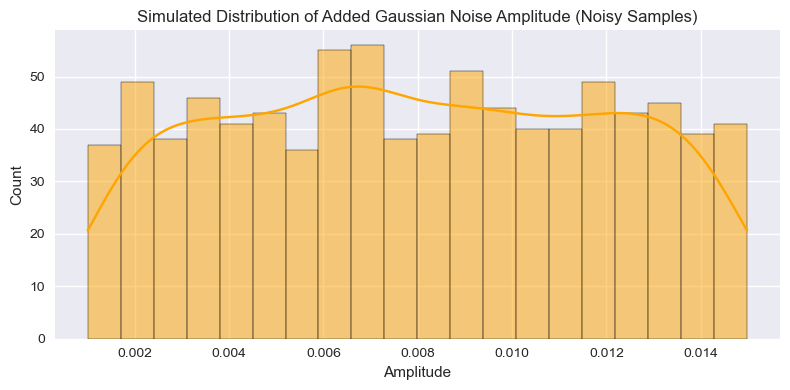

In [2]:
# Noise Augmentation Summary
print("\n🧪 Noise Augmentation Info:")
print("→ Gaussian Noise added to all samples in noisy set.")
print("→ Noise amplitude randomly chosen between 0.001 and 0.015")
print("→ 50% chance of Time Stretching (0.8x to 1.25x)")
print("→ 50% chance of Pitch Shifting (-4 to +4 semitones)")

# Simulate noise amount distribution 
simulated_noise = np.random.uniform(0.001, 0.015, size=len(df[df['category'] == 'noisy']))
plt.figure(figsize=(8, 4))
sns.histplot(simulated_noise, bins=20, kde=True, color='orange')
plt.title("Simulated Distribution of Added Gaussian Noise Amplitude (Noisy Samples)")
plt.xlabel("Amplitude")
plt.tight_layout()
plt.show()

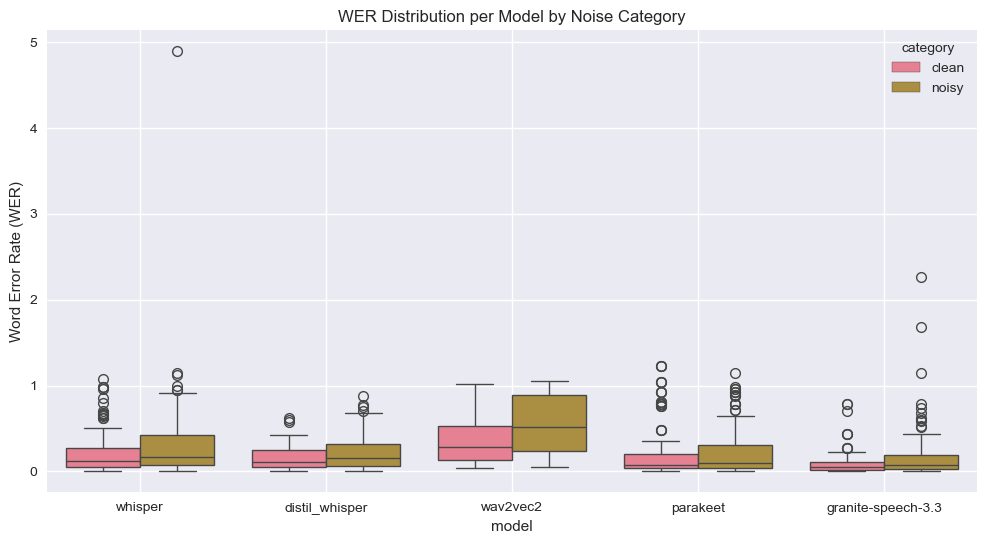

In [3]:
# WER Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="model", y="wer", hue="category")
plt.title("WER Distribution per Model by Noise Category")
plt.ylabel("Word Error Rate (WER)")
plt.grid(True)
plt.show()

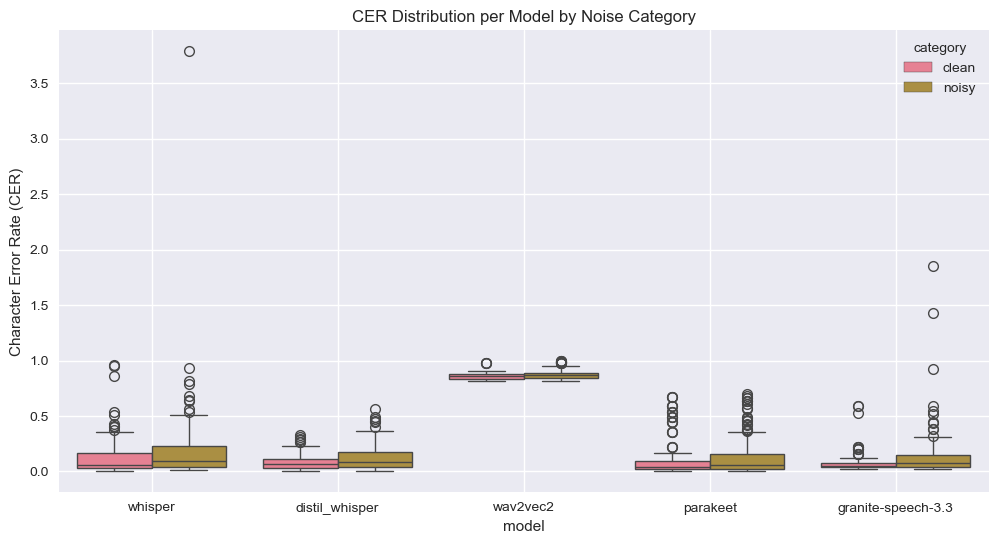

In [4]:
# CER Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="model", y="cer", hue="category")
plt.title("CER Distribution per Model by Noise Category")
plt.ylabel("Character Error Rate (CER)")
plt.grid(True)
plt.show()

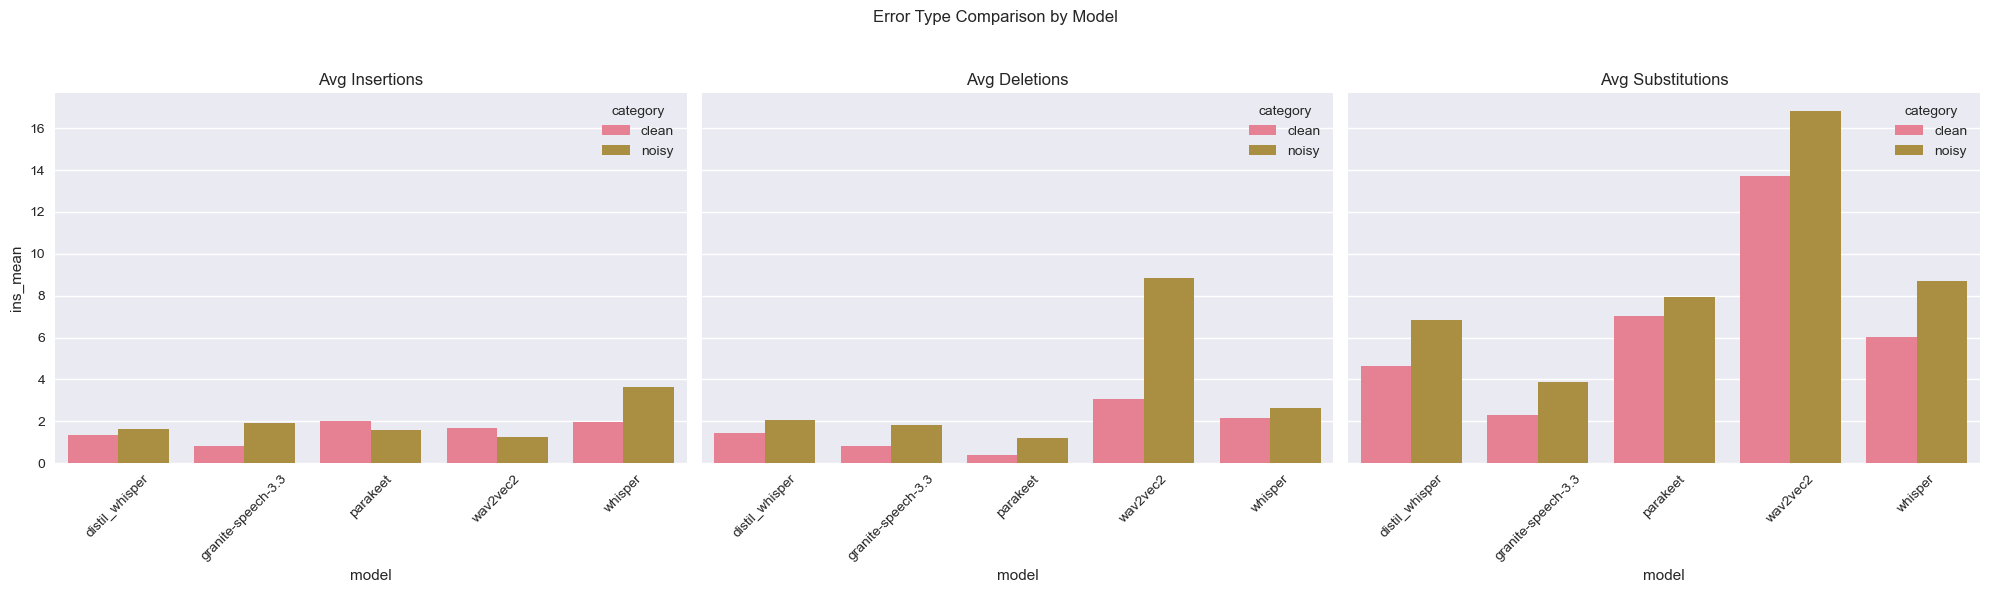

In [5]:
# Insertions, Deletions, Substitutions
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

sns.barplot(data=summary, x="model", y="ins_mean", hue="category", ax=axs[0])
axs[0].set_title("Avg Insertions")
axs[0].tick_params(axis='x', rotation=45)

sns.barplot(data=summary, x="model", y="del_mean", hue="category", ax=axs[1])
axs[1].set_title("Avg Deletions")
axs[1].tick_params(axis='x', rotation=45)

sns.barplot(data=summary, x="model", y="sub_mean", hue="category", ax=axs[2])
axs[2].set_title("Avg Substitutions")
axs[2].tick_params(axis='x', rotation=45)

plt.suptitle("Error Type Comparison by Model")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # adjust layout to make room for suptitle
plt.show()


In [ ]:
# Combined WER & CER Boxplot
melted = df.melt(
    id_vars=["model", "category"],
    value_vars=["wer", "cer"],
    var_name="metric",
    value_name="value"
)
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted, x="model", y="value", hue="metric")
plt.title("WER vs CER per Model")
plt.ylabel("Error Rate")
plt.grid(True)
plt.show()

In [ ]:
#Best open sourced models
best_clean = summary[summary["category"] == "clean"].sort_values("wer_mean").head(1)
print("✅ Best model on clean audio:")
display(best_clean)

best_noisy = summary[summary["category"] == "noisy"].sort_values("wer_mean").head(1)
print("✅ Best model on noisy audio:")
display(best_noisy)

In [ ]:
df_prop = pd.read_csv(r"C:\Users\jairo\OneDrive\Desktop\ionio\Datasets\advanced_benchmark_results.csv")
df_parakeet = pd.read_csv(r"C:\Users\jairo\OneDrive\Desktop\ionio\speech_to_text_benchmark\parakeet_benchmark_results.csv")
df_granite = pd.read_csv(r"C:\Users\jairo\Downloads\granite_speech_benchmark_run1.csv")

df = pd.concat([df_prop, df_parakeet, df_granite], ignore_index=True)

# Cleanup
df['model'] = df['model'].str.strip().str.lower()
df['category'] = df['category'].str.strip().str.lower()
df = df[df['model'] != 'deepspeech']

#Boxplot for WER
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='model', y='wer', hue='category')
plt.title("WER Distribution per Model (Clean vs Noisy)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Bar plots for Insertions, Deletions, Substitutions
for err_type in ['insertions', 'deletions', 'substitutions']:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df, x='model', y=err_type, hue='category', estimator='mean')
    plt.title(f"Mean {err_type.capitalize()} per Model (with SD)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Summary Table
summary = df.groupby(['model', 'category'])[['wer', 'insertions', 'deletions', 'substitutions']].mean().round(3)
print("Mean Error Metrics by Model & Category:\n")
print(summary)

# Best models by lowest average WER
best_clean = summary.loc[(slice(None), 'clean'), 'wer'].idxmin()
best_noisy = summary.loc[(slice(None), 'noisy'), 'wer'].idxmin()

print("\n✅ Best Model (Clean):", best_clean[0], "| WER:", summary.loc[best_clean, 'wer'])
print("✅ Best Model (Noisy):", best_noisy[0], "| WER:", summary.loc[best_noisy, 'wer'])

# Difference in WER between clean and noisy
wer_pivot = df.pivot_table(index='model', columns='category', values='wer', aggfunc='mean')
wer_pivot['wer_diff_noisy_minus_clean'] = (wer_pivot['noisy'] - wer_pivot['clean']).round(3)
print("\nWER Difference (Noisy - Clean):\n")
print(wer_pivot[['wer_diff_noisy_minus_clean']].sort_values(by='wer_diff_noisy_minus_clean'))
